# Project 1 : Monte Carlo Simulation of the One-Dimensional Ising Model

## Context and Motivation
- The Ising model is one of the pillars of statistical mechanics, providing a fundamental framework for studying phase transitions and magnetic systems.
- While the one-dimensional (1D) version of this model does not exhibit a phase transition at non-zero temperatures, it serves as an essential pedagogical tool and a benchmark for numerical methods.
- This project focuses on simulating a chain of $N$ spins interacting via the exchange energy $J$ in the absence of an external magnetic field.

## Theoretical Background
- In the 1D Ising model, the energy of a configuration is determined by the interaction between nearest neighbors.
- One of the key objectives of this study is to compare numerical results obtained via the Metropolis algorithm with exact analytical solutions. Specifically, we will verify the internal energy $E(T)$ against the theoretical formula:
 $$E(T) = -N \tanh \beta J \quad \text{with} \quad \beta = \frac{1}{k_B T} $$

## Objectives of the Project
The primary goal of this work is to implement a Monte Carlo simulation using the heat bath equilibrium method to explore the thermodynamic properties of the system. The project is structured around the following key tasks:
- **Algorithm Implementation:** Developing a robust simulation using periodic boundary conditions and the Metropolis algorithm.
- **Thermalization Analysis:** Estimating the time required for the system to reach equilibrium starting from different initial configurations (all spins up or random).
- **Thermodynamic Observables:** Computing energy $\langle E \rangle$, magnetisation $\langle M \rangle$, specific heat $C$, and magnetic susceptibility $\chi$ as functions of time $t$ and temperature $T$.
- **Experimental Validation:** Applying the model to a real-world material, FeTAC, by utilizing its specific exchange interaction $J/k = 17.4K$.


---

## Python 

### import

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import importlib
importlib.reload(utils)

from utils import *

### Constants

In [40]:
# Constante Physique
global N, spins, KB, N_thermalisation

N = 100 # Nombre de spins dans la chaine
spins = (np.random.randint(2, size = N) -0.5)*2 # Notre système aléatoir

KB = 1. # Constante de Boltzmann
J = 1. # Constante d'intéraction avec le proche voisin
h = 0. # Constante Magnétisme = 0 cause of an absence of an external magnetic field

Ti = 10 # Température initial du système
Tf = 1 # Température final du système

TIME = 10 # Temps de simulation

# Constant numérique
dT = 0.1 # pas entre chaque temperature que notre systeme va atteindre
T = np.arange(Ti, Tf+np.sign(Tf-Ti)*dT, np.sign(Tf-Ti)*dT) # liste de température par le quel le systeme va passser

N_thermalisation = TIME * 500 # Nombre de pas de temps pour thérmaliser notre système 
Nt = TIME * 100 # Nombre de pas de temps pour obtenir des mesures utilisable a chaque temperature que notre systeme atteind

### Functions

#### Hamiltonian of the Ising model in 1D :

- $H = - J \Sigma_{i=1}^{N} s_is_{i+1} + h \Sigma_{i=1}^{N} s_i \quad s_i = \pm 1 \quad \text{with PBC :} \quad s_{N+1} = s_{1} $

#### Magnetisation :

- $ M = \frac{\Sigma_{i=1}^{N} s_i}{N} $

#### Probalilty :

- $ P_{E_n} = e^{-E_n \beta}$

#### Suceptibility :

- $\chi = \beta(\langle m^2\rangle-\langle m\rangle^2)$

#### Specific Heat :

- $ C_v = \frac{\beta^2}{N}(\langle E^2\rangle-\langle E\rangle^2) $

#### Evolution in Monte Carlo method

- Change one random $s_i$,
- Compute the $\Delta E$,
- Check if we accept the change,
- Apply or not the change.

In [41]:
def compute_E(J : float, h : float) -> float:
  return -J*( np.sum(spins[:-1]*spins[1:]) + spins[0]*spins[-1] ) - h*np.sum(spins) # le terme spins[0]*spins[-1] pour la PBC

def E_theoric(J : float, T : float) -> float:
  return - N * np.tanh(J / (T*KB))

def compute_m() -> float:
  return np.mean(spins)

def compute_P(E : float, T : float) -> float:
  return np.exp(-E/(T*KB))

def compute_suceptibility(m : np.array, T : float) -> float:
  return variance(m) / (T*KB)

def compute_specific_heat(E : np.array, T : float) -> float:
  return variance(E)/(N*T*T*KB*KB)

def compute_dE(i : int) -> float:
  return 2*J*spins[i]*(spins[i-1] + spins[(i+1)%N])

def evolution(T : float) -> None :
  i = np.random.randint(N)
  if compute_P(compute_dE(i),T) > np.random.rand() :
    spins[i] = -spins[i]
  return 

def thermalisation(T : float) -> None :
  for _ in range(N_thermalisation) :
    spins = evolution(T)
  return 

### Simulation

We need in our simulation three parts :

- Gradual temperature change: we need to gradually increase (or decrease) the temperature in order to maintain a more realistic simulation.
- Thermalization, which allows our system to reach temperature $T_j$.
- Evolution at each temerature $T_j$ in order to simulate all state possible to perform good average in our simulation.

In [42]:
# Init
m_list, E_list, E_theoric_list, suceptibility_list, specific_heat_list = [], [], [], [], [] # liste of measurement depending of time
E_T_list, m_T_list = [], [] # liste of measurement depending of Temperature

# Evolution of the temp
for Tj in T :
  thermalisation(Tj)
  m, E = [], []
  for _ in range(Nt) :
    evolution(Tj)

    # Calcul des magnétisations et énergies
    m_j = compute_m()
    E_j = compute_E(J,h)

    # Stock les valeur
    m_list.append(m_j)
    E_list.append(E_j)
    E_theoric_list.append(E_theoric(J,Tj))
    
    # Stock pour Suceptibility et Heat_Capacity
    m.append(m_j)
    E.append(E_j)
  E_T_list.append(np.mean(E))
  m_T_list.append(np.mean(m))
  suceptibility_list.append(compute_suceptibility(np.array(m), Tj))
  specific_heat_list.append(compute_specific_heat(np.array(E), Tj))

--- 

### Plot depending on the time

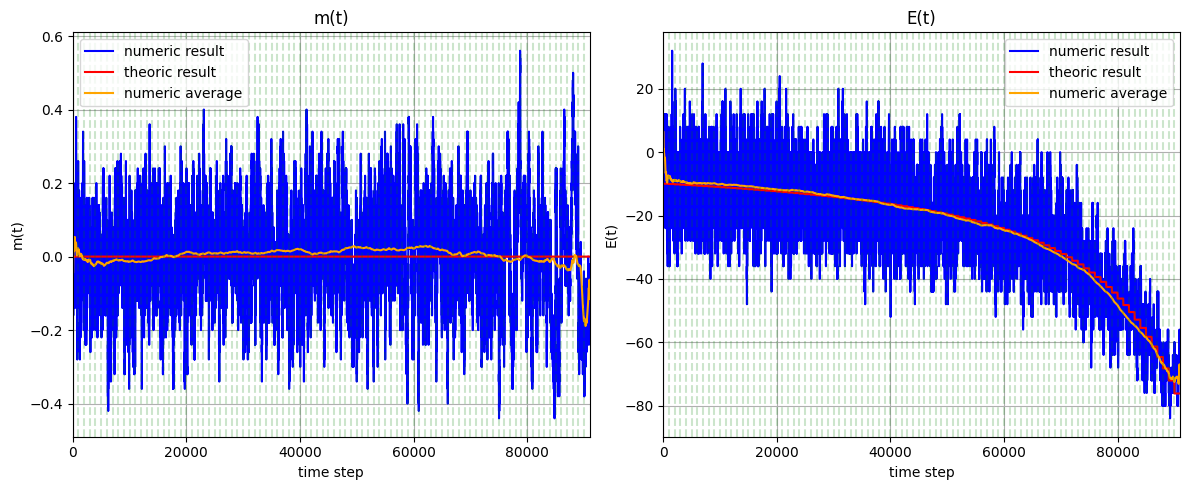

In [51]:
plot2(np.arange(Nt*len(T)), m_list, E_list, y1_theoric= np.zeros(Nt*len(T)), y2_theoric = E_theoric_list, show_y1_average=True, show_y2_average=True, title1="m(t)", title2="E(t)", x_label='time step', Tt = range(0, Nt*len(T), Nt))


### Observation 1

The theoretical magnetisation and energy are **almost identical** than the average magnetisation and energy obtained with our simulation.

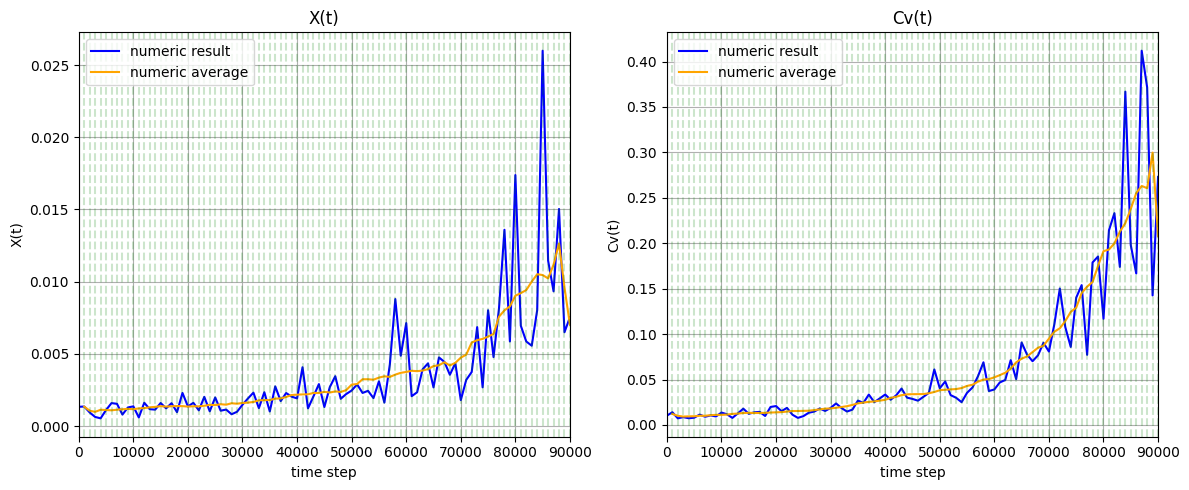

In [48]:
plot2(np.arange(len(T))*Nt, suceptibility_list, specific_heat_list, show_y1_average=True, show_y2_average=True, title1="X(t)", title2="Cv(t)", x_label='time step', Tt = range(0, Nt*len(T), Nt))

### Observation 2 

A rediger

---

### Plot depending on the Temperature

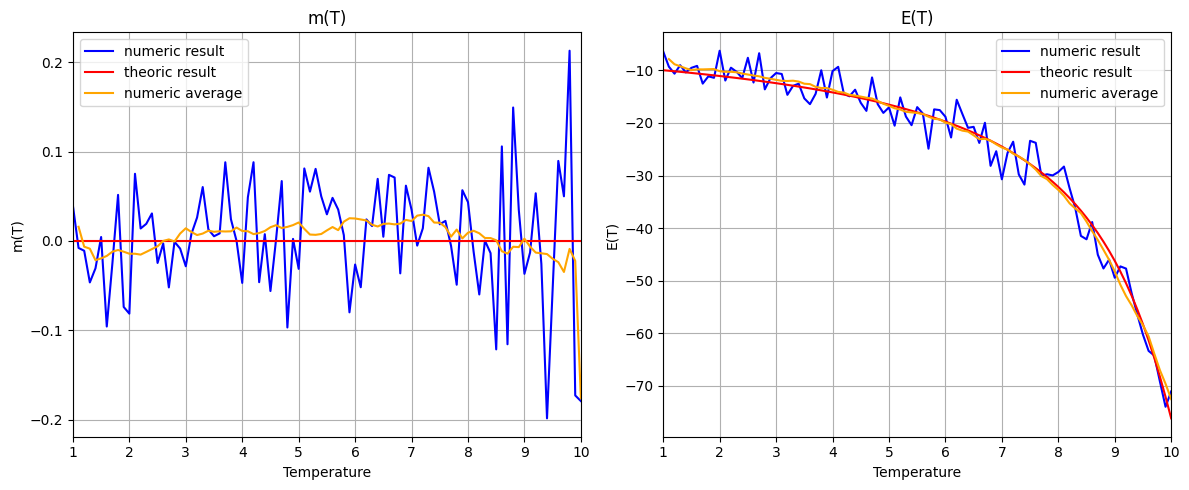

In [54]:
E_theoric_list_T = E_theoric(J, T)
plot2(np.sort(T), m_T_list, E_T_list, y1_theoric=np.zeros(len(T)), y2_theoric = E_theoric_list_T, show_y1_average=True, show_y2_average=True, title1="m(T)", title2="E(T)", x_label='Temperature')

### Observation 3

We find : $\langle m\rangle \approx 0$ and $\langle E\rangle \approx -N \tanh \beta J$.

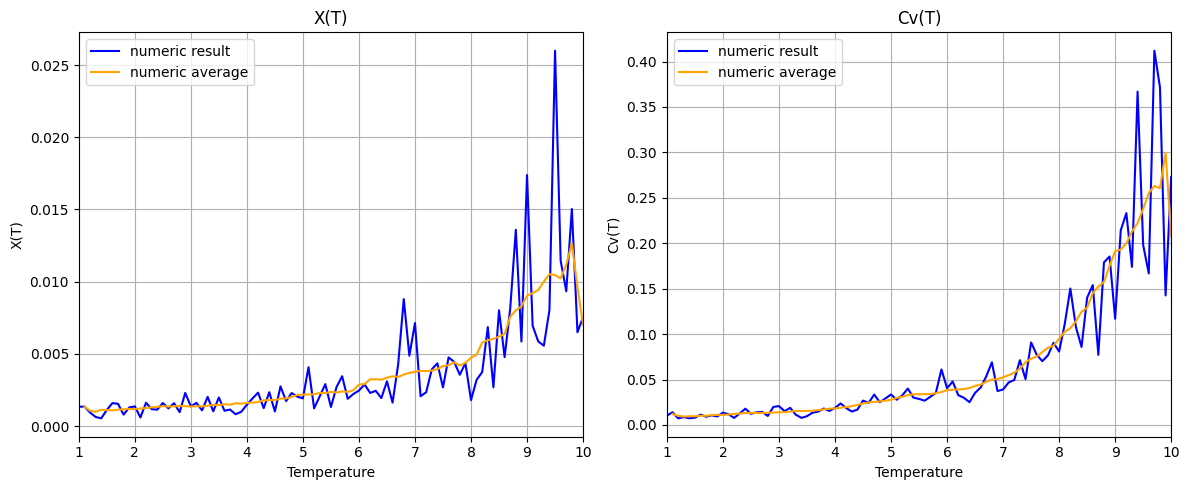

In [47]:

plot2(np.sort(T), suceptibility_list, specific_heat_list, show_y1_average=True, show_y2_average=True, title1="X(T)", title2="Cv(T)", x_label='Temperature')

### Observation 4

A rediger